# Enfriamiento Simulado

Se ha de implementar el algoritmo de Enfriamiento Simulado (ES) con las siguientes 
componentes:  
* Esquema de enfriamiento: Se implementará el esquema de Cauchy, Tk = T0/(1 + k)
* Condición de enfriamiento L(T): Se enfriará la temperatura, y finalizará a la iteración actual, cuando se haya generado un número máximo de vecinos  (independientemente de si han sido o no aceptados).
* Condición de parada: El algoritmo finalizará cuando se alcance un número máximo de iteraciones (enfriamientos).  

Se calculará la temperatura inicial en función de la siguiente fórmula:  
T0 = (μ / (-log(Φ)) ) * C(Si)  
donde T0 es la temperatura inicial, C(Si) es el costo de la solución inicial y Φ[0,1] es la probabilidad de aceptar una solución un µ por 1 peor que la inicial. En las ejecuciones se considerar Φ=µ= 0,3.  
El número de soluciones generadas en cada temperatura será L(T) = 20 y el número de enfriamientos (iteraciones) será 80 ·n.  
Se debe repetir también 10 veces con distintas semillas, partiendo de una solución inicial aleatoria.

### Librerías
- matplotlib: necesaria para la representación de la solución.
- pandas: necesaria para la representación de resultados.
- random: necesaria para el control de números aleatorios.
- datetime: necesaria para la obtención de una semilla inicial que genere las demás semillas.
- multiprocessing: necesaria para la ejecución concurrente de las soluciones.
- itertools: necesaria para combinar las semillas con los dataset en la ejecución concurrente.
- ipynb: necesaria para cargar la función busqueda_aleatorio de otro fichero. Esto permite la ejecución concurrente en Jupyter.

In [14]:
from matplotlib import pyplot as plt
import pandas as pd
from random import seed
from random import randint
from datetime import datetime
from multiprocessing import Pool, TimeoutError
import itertools
from ipynb.fs.full.algoritmo import *

### Funciones auxiliares
- cargar_fichero(nombre_fichero): devuelve un array con las ciudades almacenadas en el fichero. [ [ ciudad, posición x , posición y ] [...] ... ]
- dibujar_flecha(A, B): dibuja una flecha entre el punto A y B apuntando a B. 
- representacion(camino, nombre, distancia): representa las ciudades y el camino calculado.
- representacion_datos(result,nombre): representa la solución obtenida de la ejecución concurrente de un dataset.

In [15]:
def cargar_fichero(nombre_fichero):
    
    fichero = open( "../Dataset/" + nombre_fichero + ".tsp", 'r')
    
    for i in range(3):
        fichero.readline()
        
    numero_de_ciudades = fichero.readline().strip().split()[1]
    
    for i in range(2):
        fichero.readline()
        
    ciudades = []
    for i in range(0, int(numero_de_ciudades)):
        ciudad,x,y = fichero.readline().strip().split()[:]
        ciudades.append([int(ciudad),float(x),float(y)])  
        
    fichero.close()
    
    return ciudades

In [16]:
def dibujar_flecha(A, B):
    plt.arrow(A[0], A[1], B[0] - A[0], B[1] - A[1],
              head_width=1.3, length_includes_head=True)

In [17]:
def representacion(camino, nombre, distancia):
    
    plt.figure(figsize=(10,10))
    
    for i in range(len(camino)):
        if(i == 0):
            plt.plot(camino[i][1], camino[i][2] , "o", color="green")
        else:
            plt.plot(camino[i][1], camino[i][2] , "*", color="red")
        
        if(i<len(camino)-1):
            dibujar_flecha([camino[i][1], camino[i][2]],[camino[i+1][1], camino[i+1][2]])
        else:
            dibujar_flecha([camino[i][1], camino[i][2]],[camino[0][1], camino[0][2]])
    
    plt.title(nombre + " : " + str(distancia))

In [18]:
def representacion_datos(result,nombre):
    semilla_coste = pd.DataFrame(columns=["Semilla","Coste","Nº de evaluaciones"])
    for i in range(10):
        semilla_coste.loc[len(semilla_coste)] = [semillas[i],result[i][1], result[i][2]]
    display(semilla_coste)

    print("Media coste: ", semilla_coste[['Coste']].mean()[0])
    print("Desviación típica coste: ", semilla_coste[['Coste']].std()[0])
    print("Media nº de evaluaciones: ", semilla_coste[['Nº de evaluaciones']].mean()[0])
    print("Desviación típica nº de evaluaciones: ", semilla_coste[['Nº de evaluaciones']].std()[0])


    print()
    print("Representación de la mejor solución: ")
    indice = semilla_coste[['Coste']].idxmin()[0]


    representacion(result[indice][0], nombre, result[indice][1])

### Función para calcular el coste
Función aparte para calcular el coste de una solución, esta fue desarrollada únicamente para comprobar que las soluciones obtenidas son correctas.

In [19]:
def calcular_coste(camino):
    coste = 0
    for indice in range(len(camino)):
        if(indice < len(camino)-1):
            coste += distancia_euclidea(camino[indice],camino[indice+1])
        else:
            coste += distancia_euclidea(camino[indice],camino[0])
    return coste

In [20]:
def distancia_euclidea(ciudad_1,ciudad_2):
    
    x1,y1 = ciudad_1[1 :]
    x2,y2 = ciudad_2[1 :]
    
    xd = x1 - x2;
    yd = y1 - y2;
    
    return round(math.sqrt( xd*xd + yd*yd ))

### Lectura de ficheros

In [21]:
st70 = cargar_fichero("st70")
ch130 = cargar_fichero("ch130")
a280 = cargar_fichero("a280")
p654 = cargar_fichero("p654")
vm1084 = cargar_fichero("vm1084")
vm1748 = cargar_fichero("vm1748")

Como el enunciado especifica que empecemos con la primera ciudad, con este algoritmo, independientemente de cuantas veces lo ejecutemos nos devolverá la misma solución. Por lo que se ejecutara solo una vez.

### Generación de semillas

In [22]:
semillas = []
dt = datetime.now()
for i in range(10):
    semillas.append(randint(0,dt.microsecond))
print("Semillas generadas:")
print(semillas)

Semillas generadas:
[20526, 198260, 133617, 17545, 209355, 91584, 41768, 236019, 251417, 60655]


#### st70

In [23]:
dataset = st70
with Pool(processes=5) as pool:
    result = pool.starmap(enfriamiento_simulado,  itertools.product(semillas,[dataset],[20]) )
representacion_datos(result,"st70")

NameError: name 'enfriamiento_simulado' is not defined

#### ch130


Semilla    Coste  Nº de evaluaciones
0  325017.0  39253.0            208000.0
1   63910.0  39290.0            208000.0
2  138777.0  38328.0            208000.0
3  469215.0  39901.0            208000.0
4  547145.0  38740.0            208000.0
5  362870.0  40017.0            208000.0
6  157160.0  39525.0            208000.0
7  247060.0  38311.0            208000.0
8  238288.0  39504.0            208000.0
9  275115.0  38502.0            208000.0

Media coste:  39137.1
Desviación típica coste:  630.5011146346654
Media nº de evaluaciones:  208000.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


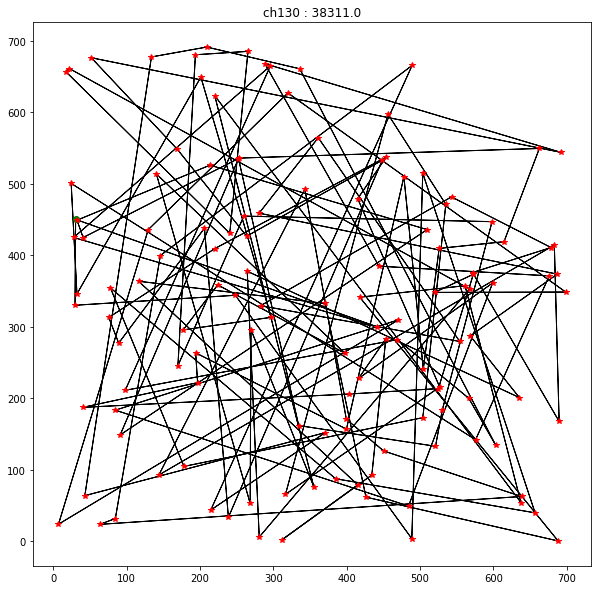

In [17]:
dataset = ch130

with Pool(processes=5) as pool:
    result = pool.starmap(enfriamiento_simulado,  itertools.product(semillas,[dataset],[20]) )
    
representacion_datos(result,"ch130")

#### a280

Semilla    Coste  Nº de evaluaciones
0  325017.0  29349.0            448000.0
1   63910.0  30123.0            448000.0
2  138777.0  30037.0            448000.0
3  469215.0  30010.0            448000.0
4  547145.0  29681.0            448000.0
5  362870.0  29726.0            448000.0
6  157160.0  29912.0            448000.0
7  247060.0  29831.0            448000.0
8  238288.0  28989.0            448000.0
9  275115.0  29434.0            448000.0

Media coste:  29709.2
Desviación típica coste:  357.51792495854903
Media nº de evaluaciones:  448000.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


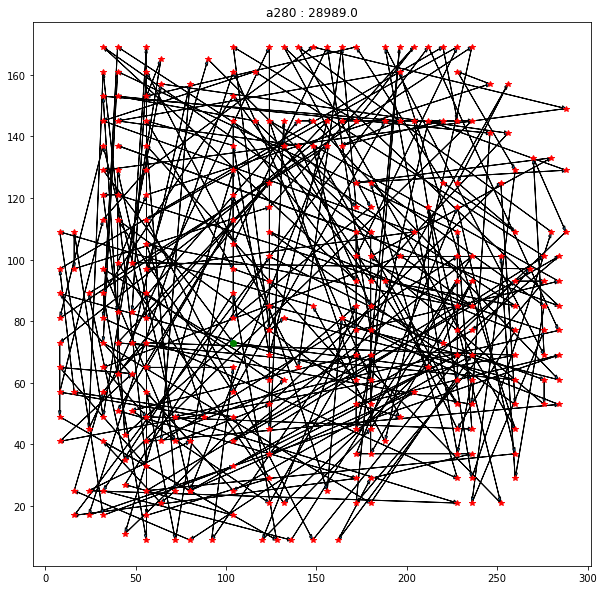

In [18]:
dataset = a280
with Pool(processes=5) as pool:
    result = pool.starmap(enfriamiento_simulado,  itertools.product(semillas,[dataset],[20]) )

representacion_datos(result,"a280")

#### p654

Semilla      Coste  Nº de evaluaciones
0  325017.0  1821620.0           1046400.0
1   63910.0  1845802.0           1046400.0
2  138777.0  1801286.0           1046400.0
3  469215.0  1825791.0           1046400.0
4  547145.0  1847925.0           1046400.0
5  362870.0  1804224.0           1046400.0
6  157160.0  1832223.0           1046400.0
7  247060.0  1819197.0           1046400.0
8  238288.0  1835147.0           1046400.0
9  275115.0  1840686.0           1046400.0

Media coste:  1827390.1
Desviación típica coste:  16131.60405642704
Media nº de evaluaciones:  1046400.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


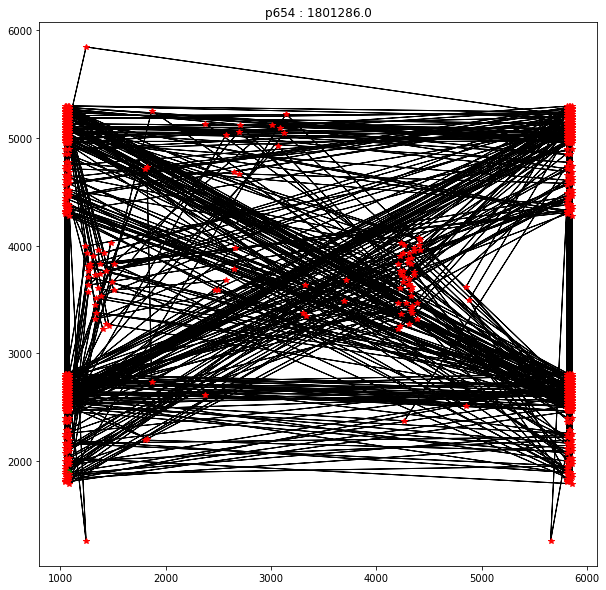

In [19]:
dataset = p654

with Pool(processes=5) as pool:
    result = pool.starmap(enfriamiento_simulado,  itertools.product(semillas,[dataset],[20]) )
    
representacion_datos(result,"p654")

#### vm1084

Semilla      Coste  Nº de evaluaciones
0  325017.0  8108103.0           1734400.0
1   63910.0  8025617.0           1734400.0
2  138777.0  7968421.0           1734400.0
3  469215.0  8043111.0           1734400.0
4  547145.0  8045064.0           1734400.0
5  362870.0  8088836.0           1734400.0
6  157160.0  8013249.0           1734400.0
7  247060.0  8043663.0           1734400.0
8  238288.0  8000436.0           1734400.0
9  275115.0  8011795.0           1734400.0

Media coste:  8034829.5
Desviación típica coste:  41111.29182610431
Media nº de evaluaciones:  1734400.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


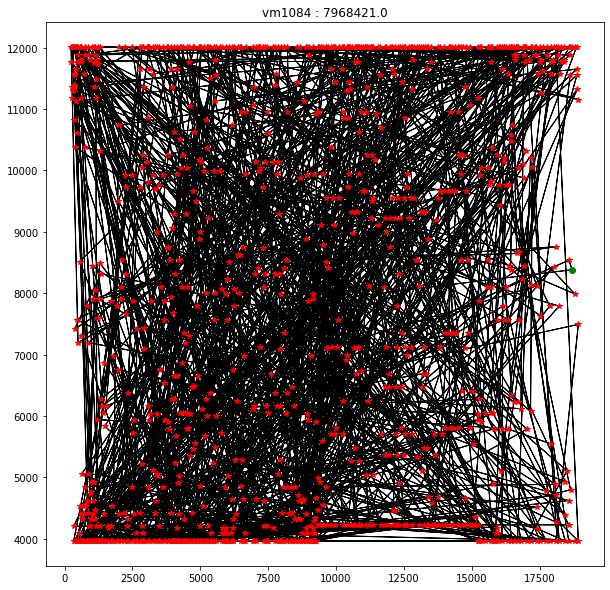

In [20]:
dataset = vm1084

with Pool(processes=5) as pool:
    result = pool.starmap(enfriamiento_simulado,  itertools.product(semillas,[dataset],[20]) )
    
representacion_datos(result,"vm1084")

#### vm1748

Semilla       Coste  Nº de evaluaciones
0  325017.0  14294015.0           2796800.0
1   63910.0  14184808.0           2796800.0
2  138777.0  14261007.0           2796800.0
3  469215.0  14272837.0           2796800.0
4  547145.0  14213236.0           2796800.0
5  362870.0  14241497.0           2796800.0
6  157160.0  14213903.0           2796800.0
7  247060.0  14285835.0           2796800.0
8  238288.0  14089338.0           2796800.0
9  275115.0  14254803.0           2796800.0

Media coste:  14231127.9
Desviación típica coste:  60658.2581305574
Media nº de evaluaciones:  2796800.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


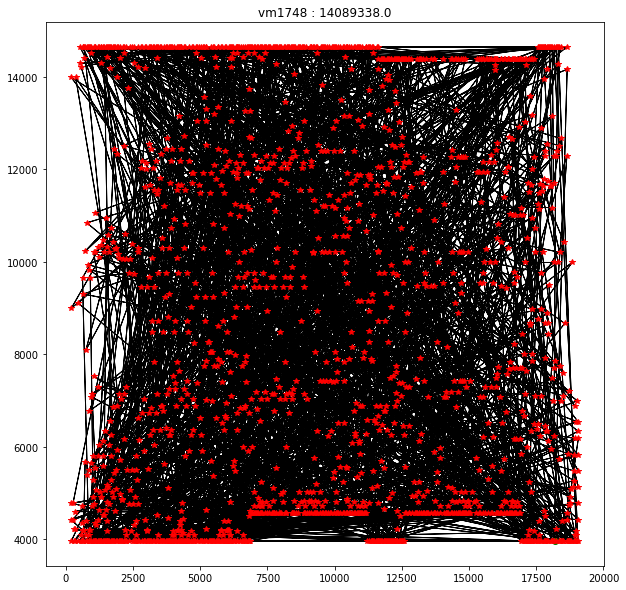

In [21]:
dataset = vm1748

with Pool(processes=5) as pool:
    result = pool.starmap(enfriamiento_simulado,  itertools.product(semillas,[dataset],[20]) )
    
representacion_datos(result,"vm1748")